In [1]:
from PIL import Image

import numpy as np
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt

from alpineml import Network
from alpineml.Checkpoint import Checkpoint
from alpineml.layer.reshape import Flatten
from alpineml.layer.shim import MLX
from alpineml.optim import SGD
from alpineml.function.activation import leaky_relu, softmax
from alpineml.function.loss import CrossEntropyLoss, cross_entropy_loss
from alpineml.layer.core import Linear, Activation
from dataset import get_cifar10


In [2]:
# load model from checkpoint
network = Network(input_shape=(32, 32, 3))

# conv block 1
network.add_layer(MLX(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# conv block 2
network.add_layer(MLX(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# feed forward
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
network.add_layer(Linear(10))

network.load(Checkpoint.read("checkpoints/simple_conv.pb"))

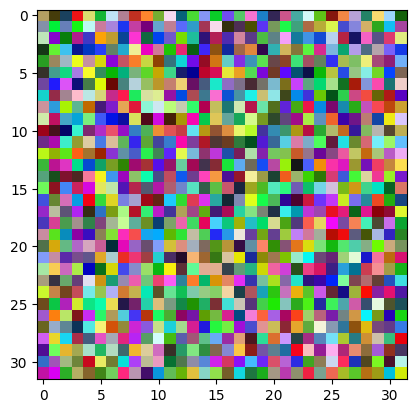

In [3]:
# create some noise
noise = mx.random.uniform(0, 255, (32, 32, 3))
noise_img = Image.fromarray(np.array(noise).astype('uint8'))
plt.imshow(noise_img)

In [4]:
# prepare to optimize the input image (noise)
network.freeze()
optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_network(network)
optimizer.bind_loss_fn(cross_entropy_loss)

In [5]:
# Cifar-10 labels
#   0 -> Airplane
#   1 -> Automobile
#   2 -> Bird
#   3 -> Cat
#   4 -> Deer
#   5 -> Dog
#   6 -> Frog
#   7 -> Horse
#   8 -> Ship
#   9 -> Truck

x = noise.reshape(1, *noise.shape)  # batch of 1 image

y = np.zeros((10,))  # one-hot encoded label
y[0] = 1  # airplane

grad = optimizer.step(x, y)
print(np.array(grad))

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


In [6]:
y_pred = network.forward(x)
print(np.array(y_pred))
print(np.array(y), y.dtype)

print("------------")

y_pred -= mx.max(y_pred, axis=1, keepdims=True) # numerical stability
print(np.array(y_pred))
exp_y = mx.exp(y_pred / 100)
print(np.array(exp_y))
y_prob = exp_y / mx.sum(exp_y, axis=1, keepdims=True)
print(np.array(y_prob))

print("------------")

grad = cross_entropy_loss.derivative(y_pred, y)
for layer in reversed(network.layers):
    print(np.array(grad))
    print()
    grad = layer.backward(grad)

[[ 2021.5542   -406.3377  -1598.5546   -392.32336    90.62307 -2695.5562
   -167.46439   965.2442   1029.4755    994.4569 ]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] float64
------------
[[    0.      -2427.8918  -3620.109   -2413.8774  -1930.9312  -4717.1104
  -2189.0186  -1056.31     -992.07874 -1027.0973 ]]
[[1.0000000e+00 2.8562706e-11 1.8969996e-16 3.2859673e-11 4.1121866e-09
  3.2647478e-21 3.1132419e-10 2.5852563e-05 4.9142429e-05 3.4623663e-05]]
[[9.9989045e-01 2.8559577e-11 1.8967918e-16 3.2856075e-11 4.1117363e-09
  3.2643901e-21 3.1129008e-10 2.5849731e-05 4.9137045e-05 3.4619869e-05]]
------------
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]]

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  